In [1]:
import nltk
import re 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Donald Trumps Facebook Statuses.csv')
df.head()

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,153080620724_10157915294545725,Beautiful evening in Wisconsin- THANK YOU for ...,Timeline Photos,photo,https://www.facebook.com/DonaldTrump/photos/a....,10/17/2016 20:56:51,6813.0,543.0,359.0,6178.0,572.0,39.0,17.0,0.0,7.0
1,153080620724_10157914483265725,The State Department's quid pro quo scheme pro...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,10/17/2016 18:00:41,33768.0,3644.0,17653.0,26649.0,487.0,1155.0,75.0,191.0,5211.0
2,153080620724_10157913199155725,Crooked Hillary's State Department colluded wi...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,10/17/2016 15:34:46,85627.0,8810.0,32594.0,73519.0,2943.0,1020.0,330.0,263.0,7552.0
3,153080620724_10157912962325725,"JournoCash: Media gives $382,000 to Clinton, $...","JournoCash: Media gives $382,000 to Clinton, $...",link,http://www.washingtonexaminer.com/journocash-m...,10/17/2016 14:17:24,22696.0,3665.0,5082.0,14029.0,122.0,2091.0,241.0,286.0,5927.0
4,153080620724_10157912187170725,"Exclusive: ""O'Keefe Video Sting Exposes 'Bird-...",O'Keefe Reveals 'Bird-Dogging' to Incite Viole...,link,http://www.breitbart.com/big-government/2016/1...,10/17/2016 12:03:19,40729.0,4905.0,17087.0,26472.0,178.0,2588.0,154.0,417.0,10922.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4540 entries, 0 to 4539
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         4539 non-null   object 
 1   status_message    3794 non-null   object 
 2   link_name         2715 non-null   object 
 3   status_type       4160 non-null   object 
 4   status_link       2983 non-null   object 
 5   status_published  4160 non-null   object 
 6   num_reactions     4160 non-null   float64
 7   num_comments      4160 non-null   float64
 8   num_shares        4160 non-null   float64
 9   num_likes         4160 non-null   float64
 10  num_loves         4160 non-null   float64
 11  num_wows          4160 non-null   float64
 12  num_hahas         4160 non-null   float64
 13  num_sads          4160 non-null   float64
 14  num_angrys        4159 non-null   float64
dtypes: float64(9), object(6)
memory usage: 532.2+ KB


### 1. Use charts (histogram/bar graph) to display the distribution of types of statuses (photo, video, link, and status).

In [4]:
df['status_type'].value_counts()

photo                    1539
status                   1177
link                      763
video                     679
http://bit.ly/2duCRlw       1
event                       1
Name: status_type, dtype: int64

Inconsistency in status type column.  This row will be removed 

In [5]:
df = df[df['status_type'] != 'http://bit.ly/2duCRlw']

In [6]:
df['status_type'].value_counts()

photo     1539
status    1177
link       763
video      679
event        1
Name: status_type, dtype: int64

<AxesSubplot:>

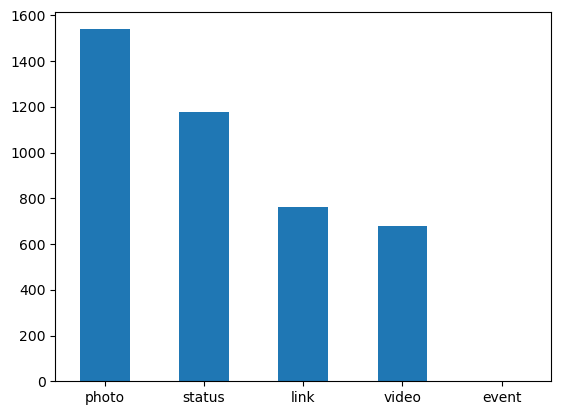

In [7]:
df['status_type'].value_counts().plot(kind='bar', rot=360)

### 2. Plot a chart showing the progression of likes, loves, and sads, and angrys over time

In [8]:
# converting status_published to datetime type 
df['status_published'] = pd.to_datetime(df['status_published'])
df['status_published'].dtype

dtype('<M8[ns]')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4539 entries, 0 to 4539
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   status_id         4538 non-null   object        
 1   status_message    3793 non-null   object        
 2   link_name         2714 non-null   object        
 3   status_type       4159 non-null   object        
 4   status_link       2982 non-null   object        
 5   status_published  4159 non-null   datetime64[ns]
 6   num_reactions     4159 non-null   float64       
 7   num_comments      4159 non-null   float64       
 8   num_shares        4159 non-null   float64       
 9   num_likes         4159 non-null   float64       
 10  num_loves         4159 non-null   float64       
 11  num_wows          4159 non-null   float64       
 12  num_hahas         4159 non-null   float64       
 13  num_sads          4159 non-null   float64       
 14  num_angrys        4159 n

In [10]:
new_df = df[['status_published','num_likes','num_loves','num_sads','num_angrys']].copy()

In [11]:
new_df.head()

,status_published,num_likes,num_loves,num_sads,num_angrys
0,2016-10-17 20:56:51,6178.0,572.0,0.0,7.0
1,2016-10-17 18:00:41,26649.0,487.0,191.0,5211.0
2,2016-10-17 15:34:46,73519.0,2943.0,263.0,7552.0
3,2016-10-17 14:17:24,14029.0,122.0,286.0,5927.0
4,2016-10-17 12:03:19,26472.0,178.0,417.0,10922.0


In [12]:
max_date = new_df['status_published'].max()
max_date

Timestamp('2016-10-17 20:56:51')

In [13]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4539 entries, 0 to 4539
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   status_published  4159 non-null   datetime64[ns]
 1   num_likes         4159 non-null   float64       
 2   num_loves         4159 non-null   float64       
 3   num_sads          4159 non-null   float64       
 4   num_angrys        4159 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 212.8 KB


In [14]:
ts_df = new_df.set_index('status_published')

In [15]:
ts_df.head()

,num_likes,num_loves,num_sads,num_angrys
status_published,,,,
2016-10-17 20:56:51,6178.0,572.0,0.0,7.0
2016-10-17 18:00:41,26649.0,487.0,191.0,5211.0
2016-10-17 15:34:46,73519.0,2943.0,263.0,7552.0
2016-10-17 14:17:24,14029.0,122.0,286.0,5927.0
2016-10-17 12:03:19,26472.0,178.0,417.0,10922.0


In [16]:
ts_df.max()

num_likes     1117712.0
num_loves       53786.0
num_sads        22576.0
num_angrys      84015.0
dtype: float64

In [17]:
month_year_formatter = mdates.DateFormatter('%b, %Y')
month_year_formatter

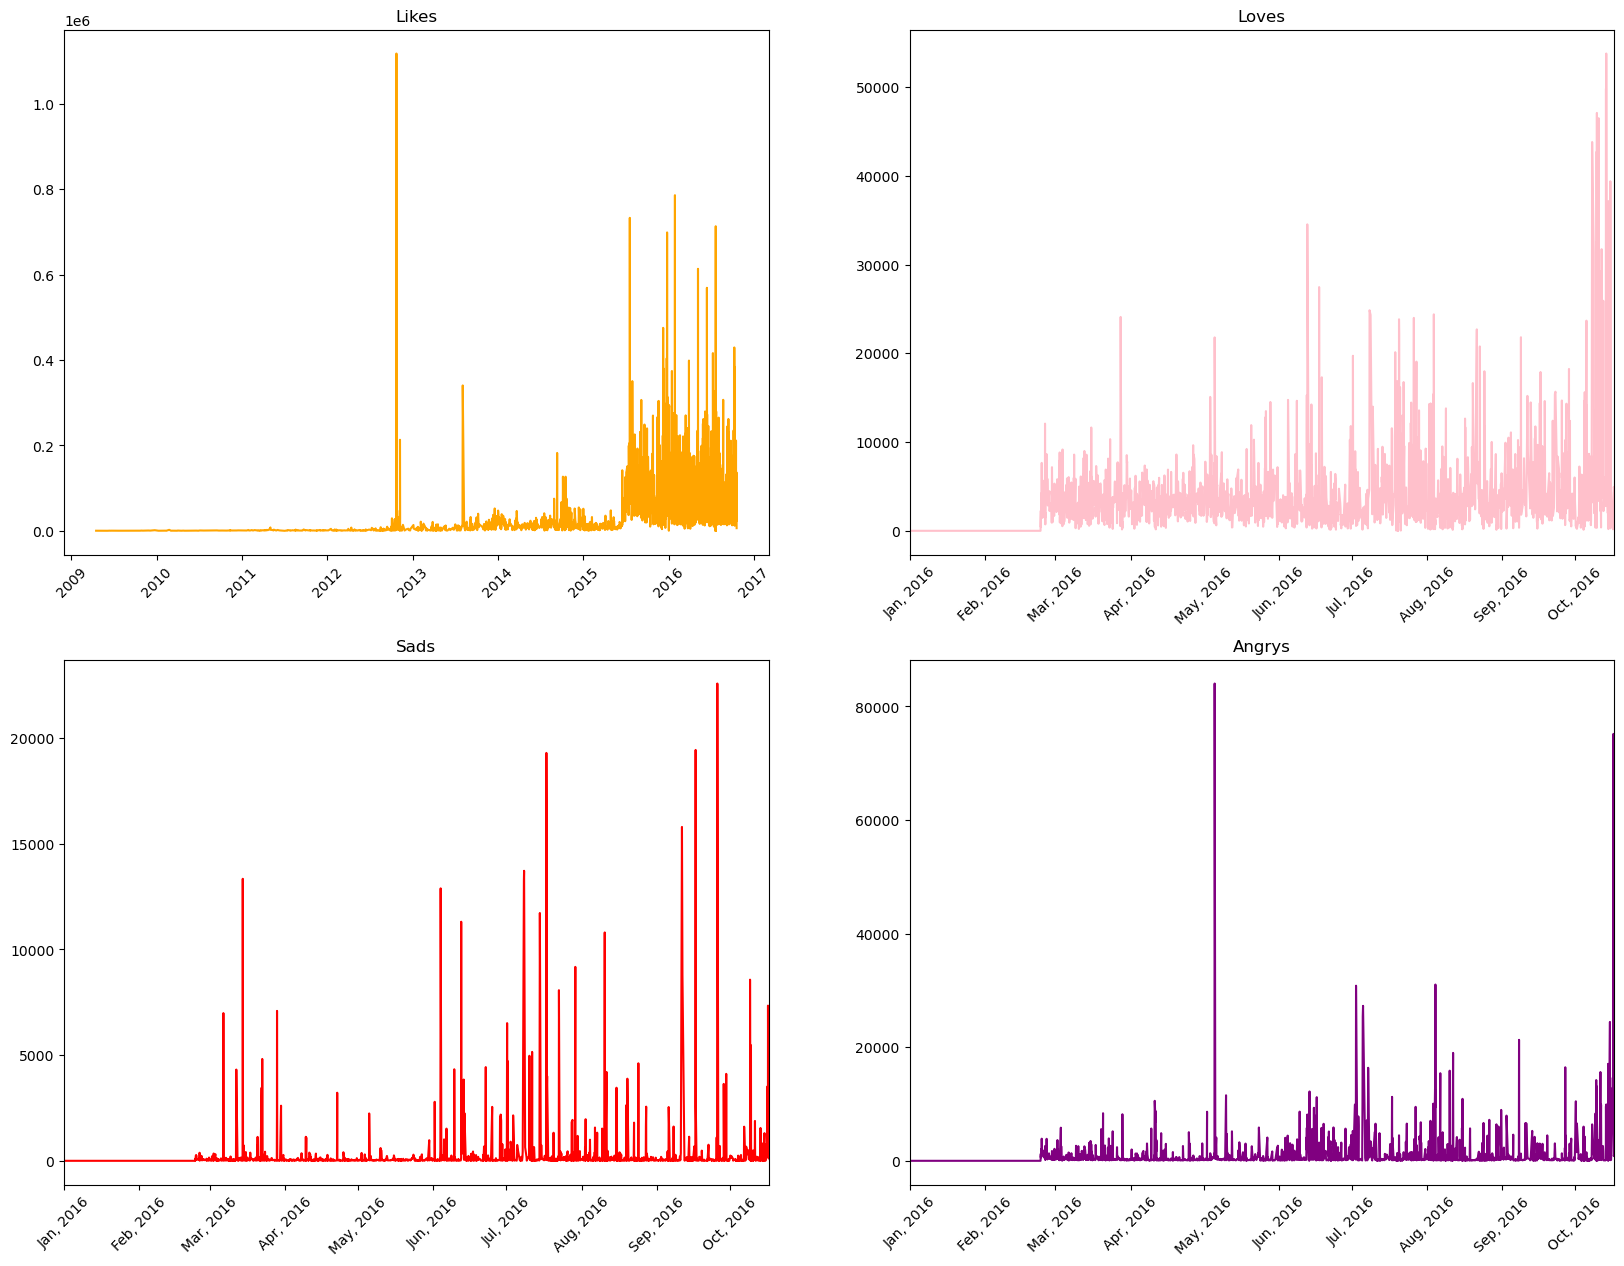

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))


# likes
ax[0, 0].plot(ts_df['num_likes'], color = 'orange')
ax[0, 0].set_title("Likes")
ax[0,0].tick_params(axis='x',labelrotation=45)

# loves
ax[0, 1].plot(ts_df['num_loves'], color = 'pink')
ax[0, 1].set(
    title="Loves",
    xlim=[datetime.date(2016, 1, 1), datetime.date(2016, 10, 17)]
)
ax[0,1].tick_params(axis='x',labelrotation=45)
ax[0, 1].xaxis.set_major_formatter(month_year_formatter)



# sads
ax[1, 0].plot(ts_df['num_sads'], color = 'red')
ax[1, 0].set(
    title="Sads",
    xlim=[datetime.date(2016, 1, 1), datetime.date(2016, 10, 17)]
)
ax[1,0].tick_params(axis='x',labelrotation=45)
ax[1, 0].xaxis.set_major_formatter(month_year_formatter)

    


# angrys
ax[1, 1].plot(ts_df['num_angrys'], color='purple')
ax[1, 1].set(
    title="Angrys",
    xlim=[datetime.date(2016, 1, 1), datetime.date(2016, 10, 17)]
)
ax[1,1].tick_params(axis='x',labelrotation=45)
ax[1, 1].xaxis.set_major_formatter(month_year_formatter)



plt.show()

### 3. What are the top reactions expressed by Trump’s Facebook audience?

<AxesSubplot:>

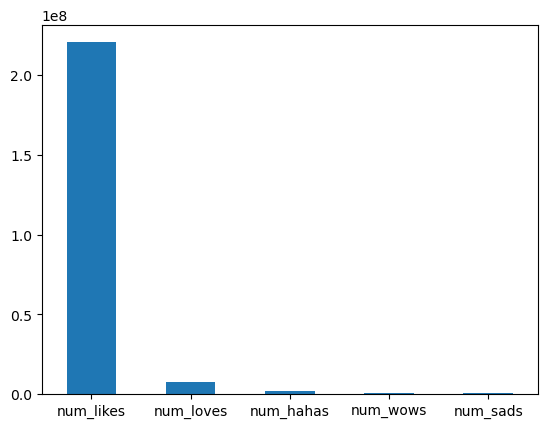

In [19]:
df.iloc[:, 9:14].sum().sort_values(ascending=False).plot(kind='bar', rot=360)

**The top reactions to epxressed by Trump's Facebook audience are likes, loves, and hahas**

In [20]:
data = df[df['status_message'].notnull()]
corpus = data['status_message'].to_list()
corpus[:3]

['Beautiful evening in Wisconsin- THANK YOU for your incredible support tonight! Everyone get out on November 8th - and VOTE! LETS MAKE AMERICA GREAT AGAIN! -DJT',
 "The State Department's quid pro quo scheme proves how CORRUPT our system is. Attempting to protect Crooked Hillary, NOT our American service members or national security information, is absolutely DISGRACEFUL. The American people deserve so much better. On November 8th, we will END this RIGGED system once and for all!",
 "Crooked Hillary's State Department colluded with the FBI and the DOJ in a DISGRACEFUL quid pro quo exchange where her staff promised FBI agents more overseas positions if the FBI would alter emails that were classified. This is COLLUSION at its core and Crooked Hillary's super PAC, the media, is doing EVERYTHING they can to cover it up. It's a RIGGED system and we MUST not let her get away with this -- our country deserves better! Vote on Nov. 8 and let's take back the White House FOR the people and BY th

### Data Cleaning 

In [21]:
class TextNormalizer(BaseEstimator, TransformerMixin): 
    
    def __init__(self): 
        self.stopwords =set(stopwords.words('english')) 
        self.lemm=WordNetLemmatizer()
    
    def lower(self, document): 
        lower = document.lower()
        return lower
    
    def remove_url(self, document): 
        p1 = r"http\S+"
        rem_url = re.sub(p1, "", self.lower(document)) #matches text from string that contains 'http' and one or more occurances of any non-whitespace characters 
        return rem_url
    
    def remove_handle(self, document):
        p3 = r"@\S+"
        rem_handle = re.sub(p3, "", self.remove_url(document))
        return rem_handle
    
    def remove_punct(self, document): 
        p2 = r"[^\w\s]|\d|_" # matches text from string that does not contain a word or a whitespace character
        rem_punc = re.sub(p2, "", self.remove_handle(document))
        return rem_punc
    
    def remove_non_english(self, document):
    
        '''
        uses ascii characters to encode the string (ascii --> digits, upper & lower case english letters, special characters)
        if a character can't be encoded, it will be ignored, in this case removed
        when a character is encoded, it converts a string to a byte 
        to convert back to a string decode() is called 
        '''

        eng_text = self.remove_punct(document).encode("ascii", errors="ignore").decode()

        return eng_text
    
    def stopword_rem(self, document): 
        tokens = word_tokenize(self.remove_non_english(document))
        stop_rem = [w for w in tokens if w not in self.stopwords]
        return stop_rem
    
    def rem_one_word(self, document): 
        one_word = [w for w in self.stopword_rem(document) if len(w) > 2]
        return one_word
    
    def get_word_pos(self, word):
        tag=nltk.pos_tag([word])[0][1][0].upper()
        tag_dict={"J":wordnet.ADJ,
                 "N":wordnet.NOUN,
                 "V":wordnet.VERB,
                 "R":wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
        
    
    def lemmatizer(self,document):
        lemma_lst=[self.lemm.lemmatize(w, self.get_word_pos(w)) for w in self.rem_one_word(document)]
        #lemma_lst=[self.lemm.lemmatize(w) for w in self.rem_one_word(document)]
        return " ".join(lemma_lst)
    
    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        for document in documents:
            yield self.lemmatizer(document)
    

In [22]:
preprocess_pipe = Pipeline(steps = [ 
                            ('norm', TextNormalizer())])

In [23]:
preprocess_pipe.fit(corpus)

Pipeline(steps=[('norm', TextNormalizer())])

In [24]:
x = preprocess_pipe.transform(corpus)

In [25]:
X = list(x)
normalized_df = pd.DataFrame(X)
normalized_df

,0
0,beautiful even wisconsin thank incredible supp...
1,state department quid pro quo scheme prof corr...
2,crooked hillary state department collude fbi d...
3,journocash medium give clinton trump margin
4,exclusive okeefe video sting expose birddoggin...
...,...
3788,check official website donald trump new book t...
3789,name
3790,follow donald trump twitter
3791,watch donald trump larry king live


### 4. a)  LDA 

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

class SklearnTopicModel(): 
    
    def __init__(self, n_topics=10):
        self.n_topics= n_topics
        self.model=Pipeline([
            ('norm', TextNormalizer()),
            ('vec', CountVectorizer(lowercase=False)),
            ('model', LatentDirichletAllocation(n_components=self.n_topics, random_state=0))
        ])
        
        
    def fit_transform(self, documents): 
        self.model.fit_transform(documents)
        
        return self.model
    
    def get_topics(self, n= 10): 
        
        ''' n is the number of top words for each topic'''
        
        vectorizer = self.model.named_steps['vec'] # accessing the vecotrizer step 
        model = self.model.steps[-1][1] # accessing the model step 
        names = vectorizer.get_feature_names() # accessing all the terms 
        topics = dict() # initializing a dictionary to store topics 
        
        for idx, topic in enumerate(model.components_):
            #print(model.components_)
            # enumerate will assing a numerical key with each term
            features = topic.argsort()[:-(n - 1): -1]
            tokens = [names[i] for i in features]
            topics[idx] = tokens
            
        return topics 
        
    
    def get_topic_word_dist(self, documents): 
        model = self.model.steps[-1][1]
        return model.components_
    
    def get_doc_topic_dist(self, documents):
        
        return self.model.transform(documents) 
    
    def get_feature_names(self, documents): 
        return get_feature_names_out(documents)
    
#     def score(self,documents):
#         return self.model['model'].score(documents)
    


if __name__ == "__main__": 
        
    lda = SklearnTopicModel()

    lda.fit_transform(corpus)

In [27]:
#lda.model['vec'].get_feature_names()

In [23]:
topics = lda.get_topics()

for topic, terms in topics.items():
    print("Topic #{}:".format(topic+1))
    print(terms)

Topic #1:
['american', 'clinton', 'hillary', 'people', 'country', 'job', 'go', 'america']
Topic #2:
['trump', 'donald', 'clinton', 'state', 'senator', 'student', 'hillary', 'university']
Topic #3:
['trump', 'great', 'donald', 'new', 'makeamericagreatagain', 'police', 'happy', 'law']
Topic #4:
['trump', 'new', 'great', 'york', 'golf', 'donald', 'one', 'people']
Topic #5:
['watch', 'tonight', 'trump', 'apprentice', 'live', 'night', 'nbc', 'show']
Topic #6:
['hillary', 'clinton', 'crooked', 'say', 'get', 'bad', 'president', 'make']
Topic #7:
['michael', 'john', 'david', 'james', 'robert', 'thomas', 'paul', 'richard']
Topic #8:
['president', 'obama', 'trump', 'iowa', 'cruz', 'great', 'time', 'campaign']
Topic #9:
['trump', 'veteran', 'president', 'today', 'one', 'well', 'obama', 'take']
Topic #10:
['great', 'america', 'thank', 'make', 'support', 'get', 'trump', 'vote']


In [24]:
#data_analyse['topic']= np.argmax(lda.get_topic_dist(corpus), axis=1)+1
data['topic'] = np.argmax(lda.get_doc_topic_dist(corpus), axis=1)+1

In [25]:
data.head()

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,topic
0,153080620724_10157915294545725,Beautiful evening in Wisconsin- THANK YOU for ...,Timeline Photos,photo,https://www.facebook.com/DonaldTrump/photos/a....,2016-10-17 20:56:51,6813.0,543.0,359.0,6178.0,572.0,39.0,17.0,0.0,7.0,10
1,153080620724_10157914483265725,The State Department's quid pro quo scheme pro...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,2016-10-17 18:00:41,33768.0,3644.0,17653.0,26649.0,487.0,1155.0,75.0,191.0,5211.0,1
2,153080620724_10157913199155725,Crooked Hillary's State Department colluded wi...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,2016-10-17 15:34:46,85627.0,8810.0,32594.0,73519.0,2943.0,1020.0,330.0,263.0,7552.0,1
3,153080620724_10157912962325725,"JournoCash: Media gives $382,000 to Clinton, $...","JournoCash: Media gives $382,000 to Clinton, $...",link,http://www.washingtonexaminer.com/journocash-m...,2016-10-17 14:17:24,22696.0,3665.0,5082.0,14029.0,122.0,2091.0,241.0,286.0,5927.0,4
4,153080620724_10157912187170725,"Exclusive: ""O'Keefe Video Sting Exposes 'Bird-...",O'Keefe Reveals 'Bird-Dogging' to Incite Viole...,link,http://www.breitbart.com/big-government/2016/1...,2016-10-17 12:03:19,40729.0,4905.0,17087.0,26472.0,178.0,2588.0,154.0,417.0,10922.0,1


In [26]:
reaction_data = data.groupby("topic")[['num_reactions', 'num_comments', 'num_shares', 
                                       'num_likes', 'num_loves', 'num_wows', 'num_hahas', 
                                       'num_sads', 'num_angrys']].sum().reset_index()

In [27]:
reaction_data

,topic,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,1,28950076.0,2489610.0,4984279.0,26916779.0,1034077.0,122512.0,213898.0,91612.0,567720.0
1,2,10708701.0,889646.0,1407511.0,10104095.0,288403.0,37761.0,95066.0,55095.0,128167.0
2,3,18982062.0,1626027.0,2676293.0,18052371.0,495599.0,36770.0,109661.0,121452.0,159580.0
3,4,11187356.0,1036142.0,1082132.0,10653679.0,304534.0,30208.0,87050.0,23112.0,88730.0
4,5,11584201.0,1670478.0,1146114.0,11000416.0,367335.0,22243.0,82203.0,15600.0,96371.0
5,6,34549763.0,3298949.0,6573844.0,32420989.0,719357.0,112829.0,574083.0,73048.0,644257.0
6,7,1032285.0,134897.0,130511.0,953495.0,56937.0,3943.0,3718.0,1648.0,12544.0
7,8,14486827.0,1290895.0,1857995.0,13918114.0,309982.0,26449.0,118263.0,37280.0,76716.0
8,9,12492130.0,1128772.0,1668638.0,12004445.0,275726.0,25777.0,86078.0,45691.0,54397.0
9,10,84958083.0,6783323.0,9431532.0,80328828.0,3614939.0,263293.0,285530.0,67954.0,388815.0


## Topic Modeling Evaluation

In [28]:
#evaluate_x=data['status_message']
cleaned_corpus=lda.model['norm'].fit_transform(corpus)
vectors=lda.model['vec'].fit_transform(cleaned_corpus)
score=lda.model['model'].score(vectors)


In [29]:
score

-557252.8416195309

In [30]:
perplex=lda.model['model'].perplexity(vectors)
perplex

1752.2848395414242

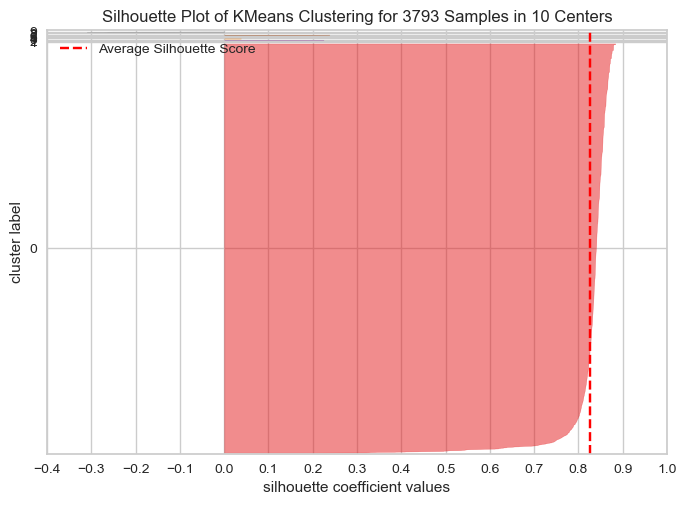

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 3793 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [33]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
vis=SilhouetteVisualizer(KMeans(n_clusters=10))
vis.fit(vectors)
vis.poof()

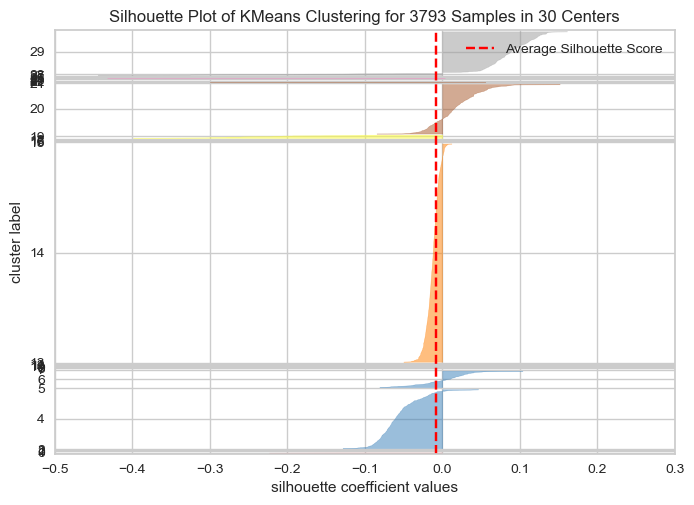

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 3793 Samples in 30 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [34]:
vis2=SilhouetteVisualizer(KMeans(n_clusters=30))
vis2.fit(vectors)
vis2.poof()

### 4. b) Happy vs. Upset Reactions Per Topic

In [33]:
reactions_happy = reaction_data['num_likes'] + reaction_data['num_loves']
reactions_upset = reaction_data['num_sads'] + reaction_data['num_angrys']

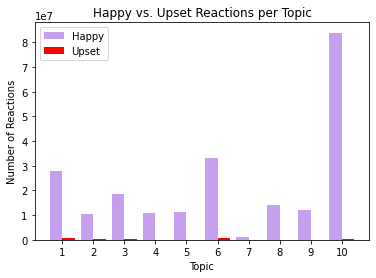

In [34]:
X_axis = np.arange(len(reaction_data['topic']))
c1 = '#C79FEF'
c2 = '#FF0000'

plt.bar(X_axis - 0.2, reactions_happy, 0.4, label = 'Happy', color=c1)
plt.bar(X_axis + 0.2, reactions_upset, 0.4, label = 'Upset', color=c2)

plt.xticks(X_axis, reaction_data['topic'])
plt.xlabel("Topic")
plt.ylabel("Number of Reactions")
plt.title("Happy vs. Upset Reactions per Topic")
plt.legend()
plt.show()

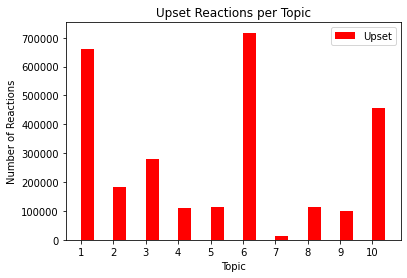

In [35]:
X_axis = np.arange(len(reaction_data['topic']))
c2 = '#FF0000'

plt.bar(X_axis + 0.2, reactions_upset, 0.4, label = 'Upset', color=c2)

plt.xticks(X_axis, reaction_data['topic'])
plt.xlabel("Topic")
plt.ylabel("Number of Reactions")
plt.title("Upset Reactions per Topic")
plt.legend()
plt.show()

### What are the themes (topics or top words) that generated a lot of shares?

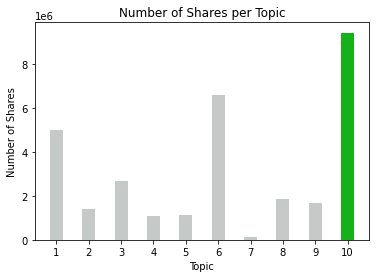

In [36]:
X_axis = np.arange(len(reaction_data['topic']))
c1 = '#15B01A'
c2 = '#C5C9C7'

colors = [c2 if (x < max(reaction_data['num_shares'])) else c1 for x in reaction_data['num_shares']]
plt.bar(X_axis, reaction_data['num_shares'], 0.4, color=colors)


plt.xticks(X_axis, reaction_data['topic'])
plt.xlabel("Topic")
plt.ylabel("Number of Shares")
plt.title("Number of Shares per Topic")
plt.show()

**topic 10 seems to have generated the most likes**

### What are the themes (topics or top words) that generated a lot of num_reactions?

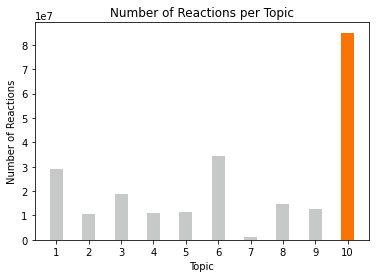

In [37]:
X_axis = np.arange(len(reaction_data['topic']))
c1 = '#F97306'
c2 = '#C5C9C7'

colors = [c2 if (x < max(reaction_data['num_reactions'])) else c1 for x in reaction_data['num_reactions']]
plt.bar(X_axis, reaction_data['num_reactions'], 0.4, color=colors)


plt.xticks(X_axis, reaction_data['topic'])
plt.xlabel("Topic")
plt.ylabel("Number of Reactions")
plt.title("Number of Reactions per Topic")
plt.show()

**Topic 10 appears to have generated the most reactions**